# A notebook for plotting main results

These include:
1. Coding of individual behavioral regressors (e.g. feedback, value, target, etc.)
2. Coding of historycal outcomes
3. Distribution of coding (laminare, depth, etc.)
4. Maybe list of units with very strong coding (cherry picked examples)
5. Maybe try to find RPE according to the paper of Kennerley (2011 Double dissociation), or just see how many units do positive or negative coding of reward.

---
# Setup

In [1]:
# @title imports
import os

from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from popy.decoding.population_decoders import *
from popy.plotting.plotting_tools import plot_keypoints
from popy.plotting.plot_cortical_grid import plot_on_cortical_grid_value_fb_custom as plot_on_cortical_grid
from popy.decoding.decoder_tools import mask_N_consecutives

import popy.config as cfg
from popy.config import COLORS

# fontsize is 8
plt.rcParams.update({'font.size': 8})


In [2]:
# @title helper functions
def load_res(fname, target=None, add_target_to_fname=True):
    floc = os.path.join(
        cfg.PROJECT_PATH_LOCAL,
        "notebooks",
        "decoders",
        "glm",
        "results",
        f"{fname}_target_{target}" if add_target_to_fname else fname,
        "scores.nc",
    )
    print(f"loading {floc}")

    ds = xr.open_dataset(floc, engine="netcdf4")
    ds.close()
    return ds.copy("deep")


def plot_prop_significant_units_full(ds_full_feedback, regressor_of_interest, time_of_interest=None, plim=0.01, title=None):
    """
    Plot the proportion of significant units for the feedback condition
    """
    cm = 1/2.54  # centimeters in inches
    fig, axs = plt.subplots(4, 2, figsize=(15 * cm, 20 * cm), sharex=True, sharey='row')
    if not title is None:
        plt.suptitle("all units - cpd feedback (vs history)")
    else:
        plt.suptitle(f'Coding of : {regressor_of_interest}')

    colors = COLORS
    styles = ["-", "--", "-.", ":", ":"]

    # thing to plot - most important!
    for m, monkey in enumerate(["ka", "po"]):
        for a, area in enumerate(["LPFC", "MCC"]):
            # get results of the two models for the current area and monkey
            ds_curr = ds_full_feedback.sel(
                unit=(ds_full_feedback.monkey == monkey) & (ds_full_feedback.area == area)
            )

            if time_of_interest is not None:
                ds_curr = ds_curr.sel(time=slice(*time_of_interest))

            # Count values greater than 0.05 in each column, ignoring NaNs
            ax = axs[0, m]
            pvals_matrix = ds_curr[f"p_vals_{regressor_of_interest}"].data  # p-values
            mean_signif = np.mean((pvals_matrix <= plim), axis=0)  
            ax.plot(
                ds_curr.time.values, mean_signif * 100, label=area,
                color=colors[area], linestyle=styles[0], lw=1
            )

            ax.set_ylabel("Percent. significant (statistical)")
            ax.set_title(f"monkey: {monkey.upper()}")

            ax = axs[1, m]
            coeffs_matrix = ds_curr[f"coeffs_{regressor_of_interest}"].data  # p-values
            mean_coeffs = np.mean((coeffs_matrix <= plim), axis=0)  
            ax.plot(
                ds_curr.time.values, mean_coeffs, label=area,
                color=colors[area], linestyle=styles[0], lw=1
            )

            ax.set_ylabel("Mean GLM coeff")

            # plot mean CPD
            ax = axs[2, m]
            # mean cpd of the significant units
            CPDs_pvals_matrix = ds_curr[f"CPDs_p_vals_{regressor_of_interest}"].data  # p-values
            mean_signif_cpd = np.mean((CPDs_pvals_matrix <= plim), axis=0)
            ax.plot(
                ds_curr.time.values, mean_signif_cpd * 100, label=area,
                color=colors[area], linestyle=styles[0], lw=1
            )

            ax.set_ylabel("Percent. significant CPD")

            ax = axs[3, m]
            # mean cpd of the significant units
            CPDs_matrix = ds_curr[f"CPDs_{regressor_of_interest}"].data  # p-values
            mean_cpd = np.nanmean(CPDs_matrix, axis=0)
            ax.plot(
                ds_curr.time.values, mean_cpd, label=area,
                color=colors[area], linestyle=styles[0], lw=1
            )

            ax.set_ylabel("CPD (%, mean without std)")


            for ax in axs[:, m]:
                # plot feedback time
                ax.axvline(0, color="black", lw=.7)

                # plot settings
                ax.legend(frameon=False)

                ax.set_xlabel("time relative to feedback (s)")
                #ax.set_ylim(0, 0.45)
                ax.grid(alpha=0.3)

                ax.spines["right"].set_visible(False)
                ax.spines["top"].set_visible(False)

    plt.tight_layout()

    return fig, axs


def plot_prop_significant_units(ds_full_feedback, regressor_of_interest, time_of_interest=None, plim=0.01, title=None):
    """
    Plot the proportion of significant units for the feedback condition
    """
    cm = 1/2.54  # centimeters in inches
    fig, axs = plt.subplots(2, 2, figsize=(15 * cm, 10 * cm), sharex=True, sharey='row')
    if not title is None:
        plt.suptitle("all units - cpd feedback (vs history)")

    colors = COLORS
    styles = ["-", "--", "-.", ":", ":"]

    # thing to plot - most important!
    for m, monkey in enumerate(["ka", "po"]):
        for a, area in enumerate(["LPFC", "MCC"]):
            # get results of the two models for the current area and monkey
            ds_curr = ds_full_feedback.sel(
                unit=(ds_full_feedback.monkey == monkey) & (ds_full_feedback.area == area)
            )

            if time_of_interest is not None:
                ds_curr = ds_curr.sel(time=slice(*time_of_interest))

            # cpd_matrix = ds_curr[f"coeffs_{regressor_of_interest}"].values  # pdf scores
            pvals_matrix = ds_curr[f"p_vals_{regressor_of_interest}"].data  # p-values
            CPDs_matrix = ds_curr[f"coeffs_{regressor_of_interest}"].data  # p-values
            # set non-significatn values to nan
            #CPDs_matrix[pvals_matrix > 0.05] = np.nan
            
            # Count values greater than 0.05 in each column, ignoring NaNs
            ax = axs[0, m]
            mean_signif = np.mean((pvals_matrix <= plim), axis=0)  
            ax.plot(
                ds_curr.time.values, mean_signif * 100, label=area,
                color=colors[area], linestyle=styles[0], lw=1
            )

            ax.set_ylabel("Percent. significant units")
            ax.set_title(f"monkey: {monkey.upper()}\ncoding: {regressor_of_interest}")

            # plot mean CPD
            ax = axs[1, m]
            # mean cpd of the significant units
            CPDs_matrix[pvals_matrix > plim] = np.nan
            mean_cpd = np.nanmean(CPDs_matrix, axis=0)
            ax.plot(
                ds_curr.time.values, mean_cpd * 100, label=area,
                color=colors[area], linestyle=styles[0], lw=1
            )

            ax.set_ylabel("Mean GLM coeff OR \nCPD (%, mean without std)")


            for ax in axs[:, m]:
                # plot feedback time
                ax.axvline(0, color="black", lw=.7)

                # plot settings
                ax.legend(frameon=False)

                ax.set_xlabel("time relative to feedback (s)")
                #ax.set_ylim(0, 0.45)
                ax.grid(alpha=0.3)

                ax.spines["right"].set_visible(False)
                ax.spines["top"].set_visible(False)

                
                
    plt.tight_layout()

    return fig, axs


def plot_prop_significant_units_on_surface(ds_full_feedback, regressor_of_interest, time_of_interest=None, plim=0.01, title=None):
    """
    Plot the proportion of significant units for the feedback condition
    """

    cm = 1/2.54  # centimeters in inches
    fig, axs = plt.subplots(1, 2, figsize=(10 * cm, 5 * cm), sharex=True, sharey=True)
    if not title is None:
        plt.suptitle("all units - cpd feedback (vs history)")

    colors = COLORS
    styles = ["-", "--", "-.", ":", ":"]

    # thing to plot - most important!
    for m, monkey in enumerate(["ka", "po"]):
        for a, area in enumerate(["LPFC", "MCC"]):
            ax = axs[m]

            # get results of the two models for the current area and monkey
            ds_curr = ds_full_feedback.sel(
                unit=(ds_full_feedback.monkey == monkey) & (ds_full_feedback.area == area)
            )

            if time_of_interest is not None:
                ds_curr = ds_curr.sel(time=slice(*time_of_interest))

            #cpd_matrix = ds_curr[f"coeffs_{regressor_of_interest}"].values  # pdf scores
            pvals_matrix = ds_curr[f"p_vals_{regressor_of_interest}"]  # p-values
            # remove nan values (remove all 'time' of a 'unit' if there is a nan in the p-values)
            pvals_matrix = pvals_matrix.dropna(dim="unit", how='any')

            # set non-significant values to nan
            #cpd_matrix[pvals_matrix > 0.05] = np.nan
            #mask = np.isnan(cpd_matrix)  # create a mask of nan values (including the non-significant ones and the nans in the original data)

            # Count values greater than 0.05 in each column, ignoring NaNs
            mean_signif = np.mean((pvals_matrix <= plim), axis=0)
            ax.plot(
                ds_curr.time.values, mean_signif, label=area,
                color=colors[area], linestyle=styles[0], lw=1
            )

            # plot feedback time
            ax.axvline(0, color="black", lw=.7)

            # plot settings
            ax.legend(frameon=False)

            ax.set_xlabel("time relative to feedback (s)")
            ax.set_ylabel("prop. of significant units")
            #ax.set_ylim(0, 0.45)
            ax.grid(alpha=0.3)

            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)

            # set title and labels
            ax.set_title(f"monkey: {monkey.upper()}\ncoding: {regressor_of_interest}")
                
    plt.tight_layout()

    return fig, axs


# plotting functions
def plot_summary_statistic(
    dss_original,
    plotting_func,
    title=None,
    p_lim=0.05,
    theme=None,
    n_extra_trials=(-1, 0),
):
    dss = [ds.copy() for ds in dss_original]

    fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
    if not title is None:
        plt.suptitle(title)

    # colors = {'LPFC': 'tab:blue', 'MCC': 'grey'}
    # iterable tab colorsú
    if theme is None:
        colors = cm.get_cmap("tab10").colors
    elif theme == 1:
        colors = {"LPFC": "tab:blue", "MCC": "grey"}
        styles = ["-", "--", "-.", ":", ":"]
        styles = {ds.attrs["model_name"]: styles[i] for i, ds in enumerate(dss)}

    for m, monkey in enumerate(["ka", "po"]):
        for a, area in enumerate(["LPFC", "MCC"]):
            ax = axs[m, a]

            # get results of the two models for the current area and monkey
            for i_ds, ds in enumerate(dss):
                ds_curr = ds.sel(unit=(ds.monkey == monkey) & (ds.area == area))
                ax.plot(
                    ds.time.values,
                    plotting_func(ds_curr, p_lim=p_lim),
                    color=colors[area] if theme == 1 else colors[i_ds],
                    linestyle=styles[ds.attrs["model_name"]] if theme == 1 else "-",
                    lw=1,
                    label=f'{ds.attrs["model_name"]}, N={(~np.isnan(ds_curr["scores"])).sum("unit")[0].values}',
                )  # , linestyle=styles[ds.attrs["model_name"]])

            # legend below plot
            ax.legend(loc="upper right")

            # plot key points
            plot_keypoints(
                ax, n_extra_trials=n_extra_trials, fontsize=8, xlabels="both"
            )
            ax.grid(alpha=0.3)

            # set title and labels
            ax.set_title(f"monkey: {monkey}, area: {area}")
            ax.set_ylabel(f"prop. of significant units")
            ax.set_xlabel("time (s)")
            # hide spines
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)

    plt.tight_layout()

    return fig, axs


# define summary statistic functions
def mean_scores(ds, p_lim=0.05):
    return np.nanmean(ds["scores"], axis=0)


def mean_scores_signif(ds, p_lim=0.05):
    ds = ds.where(ds["p_vals"] <= p_lim)
    return np.nanmean(ds["scores"], axis=0)


def prop_significants(ds, p_lim=0.05):
    n_non_nan_units = (~np.isnan(ds["scores"])).sum("unit")
    n_significant_units = (ds["p_vals"] <= p_lim).sum("unit")
    return n_significant_units / n_non_nan_units
    # return np.nanmean(ds['p_vals'] <= p_lim, axis=0)


def n_significants(ds, p_lim=0.05):
    n_significant_units = (ds["p_vals"] <= p_lim).sum("unit")
    return n_significant_units

def plot_neuron_comparison(df, save_path=None):
    """
    Create a compact figure comparing neuron distributions between two monkeys for MCC area.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'unit', 'monkey', 'area', 'feedback', and 'history' columns
    save_path : str, optional
        Path to save the figure
    """

    # Convert cm to inches (6cm × 6cm)
    cm_to_inch = 1/2.54
    figsize = (2*5*cm_to_inch, 5*cm_to_inch)  # 6cm i
    
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=figsize, sharey=True)
    
    # Categories and positions for bars
    categories = ['Feedback\nOnly', 'Value\nOnly', 'Both', 'Neither']
    colors = ['tab:green', 'tab:orange', 'tab:blue', 'white']
    x = np.arange(len(categories))
    width = .5  # Width of bars
    
    # Process each monkey's data
    monkeys = ['ka', 'po']
        
    for a, ax in enumerate(axs):
        area = ['MCC', 'LPFC'][a]
        #for i, monkey in enumerate(monkeys):
            # Filter data for current monkey and MCC area
        monkey_data = df[(df['area'] == area)]
        
        # Calculate sets
        feedback_set = monkey_data[monkey_data['signif_feedback']]
        history_set = monkey_data[monkey_data['signif_value']]

        just_feedback = monkey_data[monkey_data['signif_feedback'] & ~monkey_data['signif_value']]
        just_history = monkey_data[~monkey_data['signif_feedback'] & monkey_data['signif_value']]
        both = monkey_data[monkey_data['signif_feedback'] & monkey_data['signif_value']]
        neither = monkey_data[~monkey_data['signif_feedback'] & ~monkey_data['signif_value']]

        # Calculate counts
        total_neurons = len(monkey_data)
        n_feedback = len(feedback_set)
        n_history = len(history_set)
        n_overlap = len(both)
        n_exclusive_feedback = len(just_feedback)
        n_exclusive_history = len(just_history)
        n_neither = len(neither)
        
        # Calculate percentages
        values = [n_exclusive_feedback, n_exclusive_history, n_overlap, n_neither]
        percentages = [v/total_neurons*100 for v in values]
        
        # Plot bars
        #offset = width * (i - 0.5)
        bars = ax.bar(x, percentages, width, 
                    color=colors,
                    edgecolor='black',
                    #pattern: filled for monkey 'ka' and dotted for monkey 'po'
                    #hatch='\\' if monkey == 'po' else '.',
                    alpha=0.7)
        
        # Add value labels on bars (only counts)
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value}',
                ha='center', va='bottom',
                fontsize=6)
        
        # Customize plot
        ax.set_ylabel('% of neurons')
        ax.set_xticks(x)
        ax.set_xticklabels(categories, fontsize=8, rotation=90)
        
        # Add legend - filled grey bar for monkey 'ka' and dashed grey bar for monkey 'po'
        '''ax.bar(0, 0, color='grey', edgecolor='black', label='Monkey KA', hatch='.', alpha=0.5, width=1)
        ax.bar(0, 0, color='grey', edgecolor='black', label='Monkey PO', hatch='\\', alpha=0.5, width=1)'''
        ax.legend(fontsize=8, loc='upper left', frameon=False)

        # Add title
        ax.set_title(f'{area} Neurons', fontsize=8)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig

def plot_neuron_comparison_2(df, save_path=None):
    """
    Create a compact figure comparing neuron distributions between two monkeys for MCC area.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing 'unit', 'monkey', 'area', 'feedback', and 'history' columns
    save_path : str, optional
        Path to save the figure
    """
    # Convert cm to inches (6cm × 6cm)
    cm_to_inch = 1/2.54
    figsize = (2*5*cm_to_inch, 5*cm_to_inch)  # 6cm i
    
    # Create figure
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    # Categories and positions for bars
    channels = df['channel'].unique()
    x = np.arange(len(channels))
    width = 0.35  # Width of bars
    
    # Process each monkey's data
    monkeys = ['ka', 'po']
        
    for a, ax in enumerate(axs):
        area = ['MCC', 'LPFC'][a]
        for i, monkey in enumerate(monkeys):
            # Filter data for current monkey and MCC area
            monkey_data = df[(df['monkey'] == monkey) & (df['area'] == area)]
            
            # Calculate percentages
            percentages = [len(subdf[subdf['signif_valueŰ']])/len(subdf) for channel, subdf in monkey_data.groupby(['channel'])]
            
            # Plot bars
            offset = width * (i - 0.5)
            bars = ax.bar(x + offset, percentages, width, 
                        label=f'Monkey {monkey.upper()}',
                        color=COLORS[monkey],
                        alpha=0.9)        
        
        # Customize plot
        ax.set_ylabel('% of neurons')
        ax.set_xticks(x)
        ax.set_xticklabels(channels, fontsize=4)
        
        # Add legend
        ax.legend(fontsize=8, loc='upper right', frameon=False)

        # Add title
        ax.set_title(f'{area} Neurons', fontsize=8)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig


---
# Results 1: History of outcomes (GLM CPD)

Here we have a GLM model of:

$$
\text{SpikeCount} \sim \text{Feedback} + R_{t-1} + R_{t-2} + R_{t-3} + R_{t-4} + R_{t-5} + R_{t-6}
$$

that we fit in around the feedback event (form -2 to +3 seconds). 

We compute the CPD for the regressors ***Feeback, R_t-1, R_t-2, R_t-3, R_t-4***, with a p-value derived from ???.

***Results:***
We plot the number of units that significantly code the ***Feedback***. When we try to do so for the historical, we unfortunately do not see much significant coding. WHY???

In [9]:
# load data - 1-1 xarray datasets for all the conditions
ds_full_feedback = load_res("glm_cpd_historic_feedback")

ds_full_feedback

loading /Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/decoders/glm/results/glm_cpd_historic_feedback_target_None/scores.nc


FileNotFoundError: [Errno 2] No such file or directory: '/Users/zsombi/Library/CloudStorage/GoogleDrive-uuungvarszi@gmail.com/Other computers/My Mac/ZSOMBI/SBRI/PoPy/notebooks/decoders/glm/results/glm_cpd_historic_feedback_target_None/scores.nc'

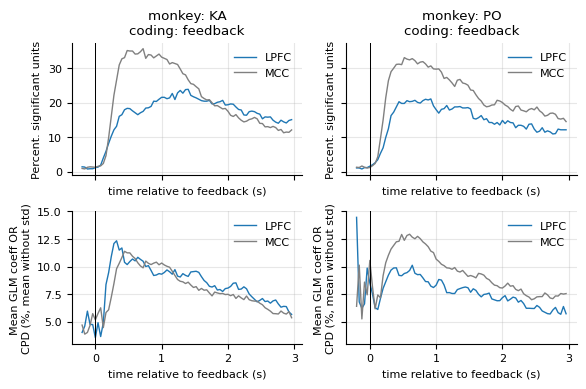

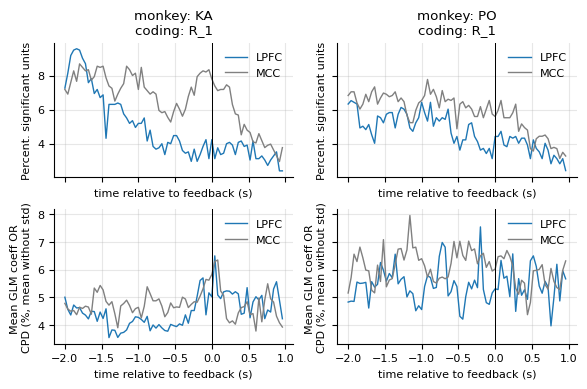

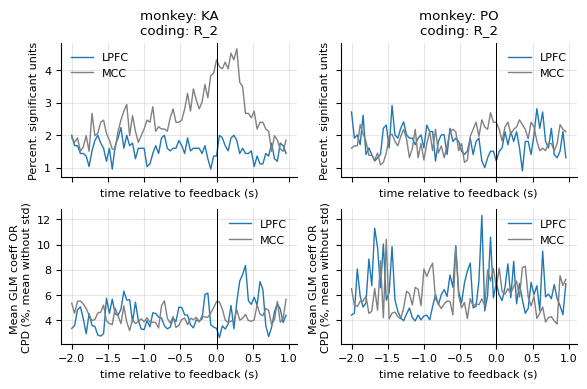

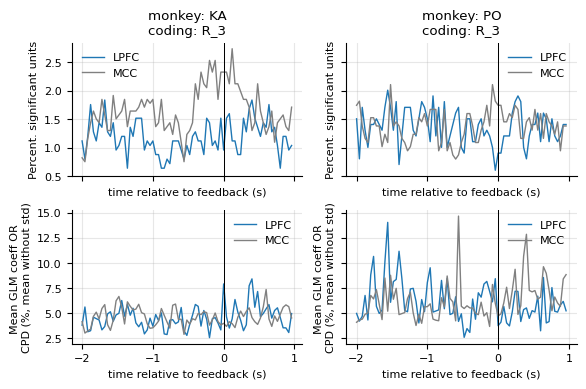

In [ ]:
regressor_of_interest = "feedback"
time_of_interest =  [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_full_feedback, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)

# save figure
'''fig.savefig(
    os.path.join('figs', f"glm_{regressor_of_interest}_prop_significant_units.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
'''
regressor_of_interest = "R_1"
time_of_interest =  [-2, 1] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_full_feedback, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)

regressor_of_interest = "R_2"
time_of_interest =  [-2, 1] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_full_feedback, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)

regressor_of_interest = "R_3"
time_of_interest =  [-2, 1] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_full_feedback, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)



In [ ]:
# load data - 1-1 xarray datasets for all the conditions
ds_fb_value_full = load_res("fb_value_cpd", add_target_to_fname=False)

ds_fb_value_full

loading /Users/zsombi/ZSOMBI/SBRI/PoPy/notebooks/decoders/glm/results/fb_value_cpd/scores.nc


<xarray.Dataset>
Dimensions:                     (unit: 4592, time: 120)
Coordinates:
  * unit                        (unit) object 'ka_230720_LPFC_05_01' ... 'po_...
  * time                        (time) float64 -3.0 -2.95 -2.9 ... 2.85 2.9 2.95
    monkey                      (unit) object ...
    session                     (unit) object ...
    area                        (unit) object ...
    channel                     (unit) object ...
Data variables: (12/14)
    scores                      (unit, time) float64 ...
    coeffs_intercept            (unit, time) float64 ...
    t_vals_intercept            (unit, time) float64 ...
    p_vals_intercept            (unit, time) float64 ...
    coeffs_feedback             (unit, time) float64 ...
    t_vals_feedback             (unit, time) float64 ...
    ...                          ...
    t_vals_value_function       (unit, time) float64 ...
    p_vals_value_function       (unit, time) float64 ...
    CPDs_feedback               (unit, time) float64 ...
    CPDs_p_vals_feedback        (unit, time) float64 ...
    CPDs_value_function         (unit, time) float64 ...
    CPDs_p_vals_value_function  (unit, time) float64 ...
Attributes:
    step_time:         0.05
    n_permutations:    500
    area:              None
    glm_predictors:    ['feedback', 'value_function']
    cpd_targets:       ['feedback', 'value_function']
    model:             glm_cpd
    neural_data_type:  spike_counts
    value_type:        continuous
    floc:              /Users/zsombi/ZSOMBI/SBRI/PoPy/notebooks/decoders/glm/...
    msg:               Fitting a GLM with feedback and value, computing CPD f...

'fig.savefig(\n    os.path.join(\'figs\', f"glm_{regressor_of_interest}_prop_significant_units.svg"),\n    dpi=300,\n    bbox_inches="tight",\n    transparent=True,\n)'

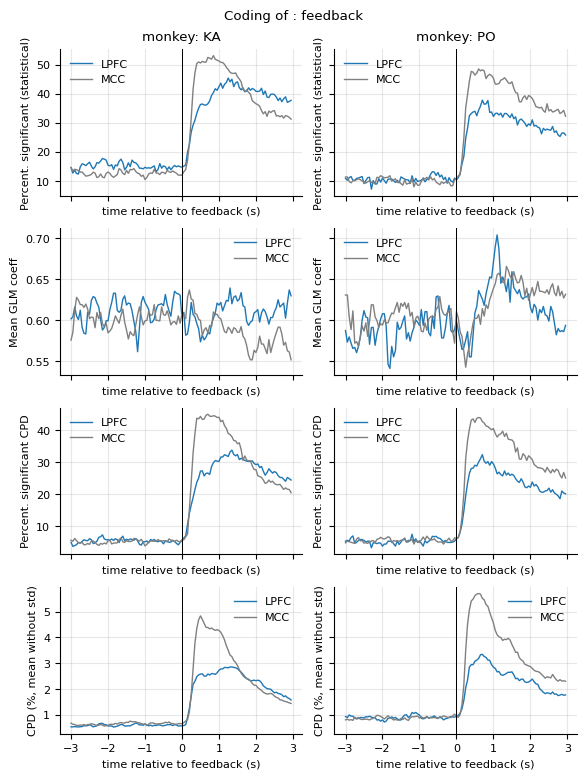

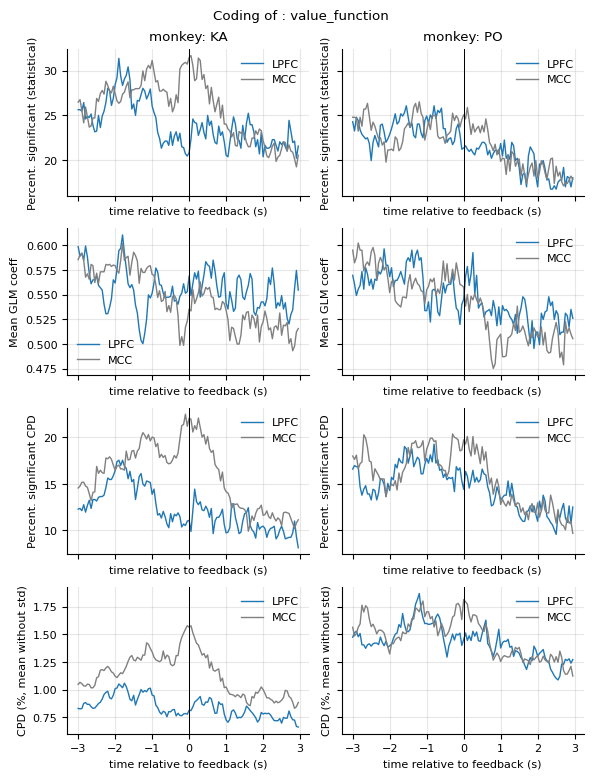

In [ ]:
regressor_of_interest = "feedback"
time_of_interest =  [-3, 3] 
fig, ax = plot_prop_significant_units_full(
    ds_fb_value_full, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.05, 
    title=None)

# save figure
'''fig.savefig(
    os.path.join('figs', f"glm_{regressor_of_interest}_prop_significant_units.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)
'''
regressor_of_interest = "value_function"
time_of_interest =  [-3, 3] # [-.2, 3] 
fig, ax = plot_prop_significant_units_full(
    ds_fb_value_full, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.05, 
    title=None)

# save figure
'''fig.savefig(
    os.path.join('figs', f"glm_{regressor_of_interest}_prop_significant_units.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)'''



## Show statistics


In [ ]:
'''#from popy.decoding.decoder_tools import mask_N_consecutives

plim = 0.01

# define times of interest
t_feedback = [.5, 2]
signifs_fb_all = ds_fb_value_full.sel(time=slice(*t_feedback)).CPDs_p_vals_feedback < plim
signifs_fb = mask_N_consecutives(signifs_fb_all, N=4, non_signif_coding='0')  # mask 3 consecutives
signifs_fb = signifs_fb.sum("time") > 0
signifs_fb'''

'#from popy.decoding.decoder_tools import mask_N_consecutives\n\nplim = 0.01\n\n# define times of interest\nt_feedback = [.5, 2]\nsignifs_fb_all = ds_fb_value_full.sel(time=slice(*t_feedback)).CPDs_p_vals_feedback < plim\nsignifs_fb = mask_N_consecutives(signifs_fb_all, N=4, non_signif_coding=\'0\')  # mask 3 consecutives\nsignifs_fb = signifs_fb.sum("time") > 0\nsignifs_fb'

/var/folders/27/vz2x5s696jv_fnk5tpw5z1gw0000gn/T/ipykernel_25547/2947613720.py:411: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8, loc='upper left', frameon=False)
/var/folders/27/vz2x5s696jv_fnk5tpw5z1gw0000gn/T/ipykernel_25547/2947613720.py:411: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8, loc='upper left', frameon=False)


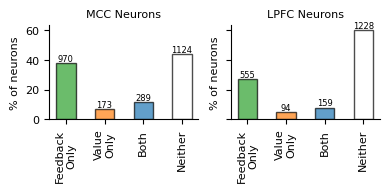

In [ ]:
plim = 0.01
n_consecutives = 4

# define times of interest
t_feedback = [.5, 2]
t_history = [-1.5, 0]

signifs_fb_all = ds_fb_value_full.sel(time=slice(*t_feedback)).CPDs_p_vals_feedback < plim
signifs_fb = mask_N_consecutives(signifs_fb_all, N=n_consecutives, non_signif_coding='0')  # mask 3 consecutives
signifs_fb = signifs_fb.sum("time") > 0

tvals_fb = ds_fb_value_full.sel(time=slice(*t_feedback)).t_vals_feedback.mean("time")
cpds_fb = ds_fb_value_full.sel(time=slice(*t_feedback)).CPDs_feedback.mean("time")

# set each unit to true if there is at least one significant time point
signifs_val_all = ds_fb_value_full.sel(time=slice(*t_history)).CPDs_p_vals_value_function < plim
signifs_val = mask_N_consecutives(signifs_val_all, N=n_consecutives, non_signif_coding='0')  # mask 3 consecutives
signifs_val = signifs_val.sum("time") > 0

tvals_val = ds_fb_value_full.sel(time=slice(*t_history)).t_vals_value_function.mean("time")
cpds_val = ds_fb_value_full.sel(time=slice(*t_history)).CPDs_value_function.mean("time")

df_unit_significances = pd.DataFrame(
    {
        "unit": ds_fb_value_full.unit.values,
        "monkey": ds_fb_value_full.monkey,
        "session": ds_fb_value_full.session,
        "area": ds_fb_value_full.area,
        "channel": ds_fb_value_full.channel,
        "signif_feedback": signifs_fb,
        "signif_value": signifs_val,
        "t_vals_feedback": tvals_fb,
        "t_vals_value": tvals_val,
    }
)

#df_unit_significances = df_unit_significances.sort_values(by=["channel"])

# show the overlap between the two sets
#fig = plot_neuron_comparison(df, save_path=None)
fig = plot_neuron_comparison(df_unit_significances, save_path=None)
fig.savefig(
    os.path.join('figs', f"glm_neuron_comparison.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

### showing weights of coding

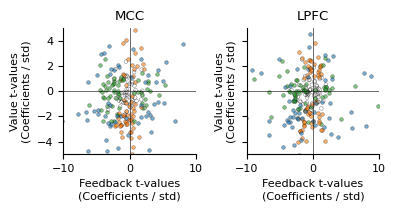

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2.15), sharex=True, sharey=True)

for (monkey, area), sub_df in df_unit_significances.groupby(["monkey", "area"]):
    if (area == "LPFC" and monkey == "ka"): ax = axs[1]
    if (area == "MCC" and monkey == "ka"): ax = axs[0]
    if (area == "LPFC" and monkey == "po"): ax = axs[1]
    if (area == "MCC" and monkey == "po"): ax = axs[0]

    # downsample: maximum 50 units for each combination of ("signif_feedback", "signif_value")
    # Modified sampling code that takes min(50, group size) samples
    sub_df = sub_df.groupby(["signif_feedback", "signif_value"]).apply(
        lambda x: x.sample(n=min(len(x), 30))
    ).reset_index(drop=True)
        
    for i, row in sub_df.iterrows():
        if not (row["signif_feedback"] or row["signif_value"]):
            color='none'
        elif row["signif_feedback"] and row["signif_value"]:
            color = "tab:blue"
        elif row["signif_feedback"]:
            color = "tab:green"
        elif row["signif_value"]:
            color = "tab:orange"     

        ax.scatter(row["t_vals_feedback"], row["t_vals_value"], facecolor=color, s=7, edgecolors='black', alpha=0.6, linewidth=0.3)

    # plot line of equality
    ax.axhline(0, color='black', lw=.5, alpha=0.5)
    ax.axvline(0, color='black', lw=.5, alpha=0.5)

    ax.set_ylim(-5, 5)
    ax.set_xlim(-10, 10)

    # set labels
    ax.set_xlabel("Feedback t-values\n(Coefficients / std)")
    ax.set_ylabel("Value t-values\n(Coefficients / std)")

    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # set title
    ax.set_title(f"{area}")

plt.tight_layout()


# save figure
floc = os.path.join('figs', f"glm_neuron_comparison_2.svg")
fig.savefig(
    floc,
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

## Show on surface

In [ ]:
def prop_significants(df, regressor):
    if len(df) == 0:
        return np.nan
    return df[regressor].mean()

plim = 0.01

prop_units = []
for (monkey, session, area), sub_df in df_unit_significances.groupby(["monkey", "session", "area"]):
        # get prop signif units for the current session (for given regressors, for given times(?) )
        n_units = len(sub_df)
        prop_signif_fb = prop_significants(sub_df, regressor='signif_feedback')
        prop_signif_value = prop_significants(sub_df, regressor='signif_value')

        # save to dict
        prop_units.append(
            {
                "monkey": monkey,
                "session": str(session),
                "area": area,
                "n_units": n_units,
                "n_signif_feedback": prop_signif_fb,
                "n_signif_value": prop_signif_value,
            }
        )

prop_units = pd.DataFrame(prop_units)
prop_units

,monkey,session,area,n_units,n_signif_feedback,n_signif_value
0,ka,010720,LPFC,16,0.375000,0.187500
1,ka,010720,MCC,22,0.727273,0.454545
2,ka,010822,LPFC,25,0.200000,0.000000
3,ka,010822,MCC,26,0.230769,0.076923
4,ka,010922,LPFC,42,0.166667,0.000000
...,...,...,...,...,...,...
207,po,291020,MCC,28,0.535714,0.285714
208,po,300322,LPFC,6,0.166667,0.166667
209,po,300322,MCC,15,0.400000,0.200000
210,po,300421,LPFC,10,0.100000,0.300000


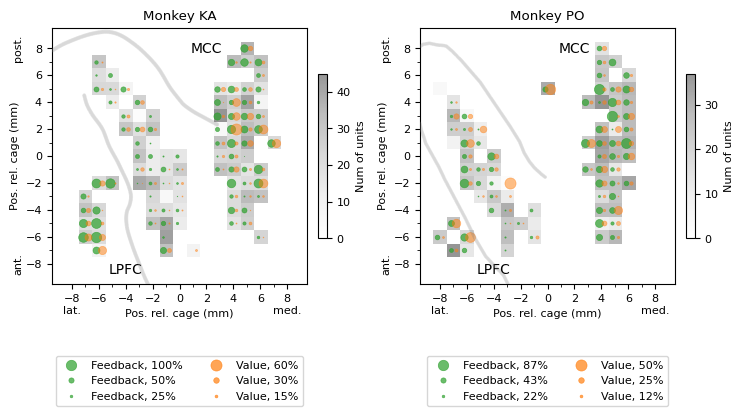

In [ ]:
# plot on cortical surface
var = "n_units"
fig, axs = plot_on_cortical_grid(
    prop_units,
    column_to_show=var,
    title=None, 
    bar_title="Num of units")

# save figure
floc = os.path.join('figs', f"glm_fb_value_on_cortical_grid.svg")
fig.savefig(floc, dpi=300, bbox_inches="tight", transparent=True)

## Simple GLM - direction of coding

In [ ]:
'''# load data - 1-1 xarray datasets for all the conditions
ds_feedback_glm = load_res("just_feedback_glm", add_target_to_fname=False)

regressor_of_interest = "feedback"
time_of_interest =  [-3, 3] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_feedback_glm, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)
'''

'# load data - 1-1 xarray datasets for all the conditions\nds_feedback_glm = load_res("just_feedback_glm", add_target_to_fname=False)\n\nregressor_of_interest = "feedback"\ntime_of_interest =  [-3, 3] # [-.2, 3] \nfig, ax = plot_prop_significant_units(\n    ds_feedback_glm, \n    regressor_of_interest=regressor_of_interest,\n    time_of_interest=time_of_interest,\n    plim=0.01, \n    title=None)\n'

In [ ]:
'''# load data - 1-1 xarray datasets for all the conditions
ds_value_glm = load_res("just_value_glm", add_target_to_fname=False)

regressor_of_interest = "value_function"
time_of_interest =  [-3, 3] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_value_glm, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)
'''

'# load data - 1-1 xarray datasets for all the conditions\nds_value_glm = load_res("just_value_glm", add_target_to_fname=False)\n\nregressor_of_interest = "value_function"\ntime_of_interest =  [-3, 3] # [-.2, 3] \nfig, ax = plot_prop_significant_units(\n    ds_value_glm, \n    regressor_of_interest=regressor_of_interest,\n    time_of_interest=time_of_interest,\n    plim=0.01, \n    title=None)\n'

In [ ]:
'''# load data - 1-1 xarray datasets for all the conditions
ds_feedback_value_glm = load_res("feedback_value_glm", add_target_to_fname=False)

regressor_of_interest = "feedback"
time_of_interest =  [-3, 3] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_feedback_value_glm, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)

regressor_of_interest = "value_function"
time_of_interest =  [-3, 3] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_feedback_value_glm, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)
'''

'# load data - 1-1 xarray datasets for all the conditions\nds_feedback_value_glm = load_res("feedback_value_glm", add_target_to_fname=False)\n\nregressor_of_interest = "feedback"\ntime_of_interest =  [-3, 3] # [-.2, 3] \nfig, ax = plot_prop_significant_units(\n    ds_feedback_value_glm, \n    regressor_of_interest=regressor_of_interest,\n    time_of_interest=time_of_interest,\n    plim=0.01, \n    title=None)\n\nregressor_of_interest = "value_function"\ntime_of_interest =  [-3, 3] # [-.2, 3] \nfig, ax = plot_prop_significant_units(\n    ds_feedback_value_glm, \n    regressor_of_interest=regressor_of_interest,\n    time_of_interest=time_of_interest,\n    plim=0.01, \n    title=None)\n'

loading /Users/zsombi/ZSOMBI/SBRI/PoPy/notebooks/decoders/glm/results/feedback_value_mixed_glm/scores.nc


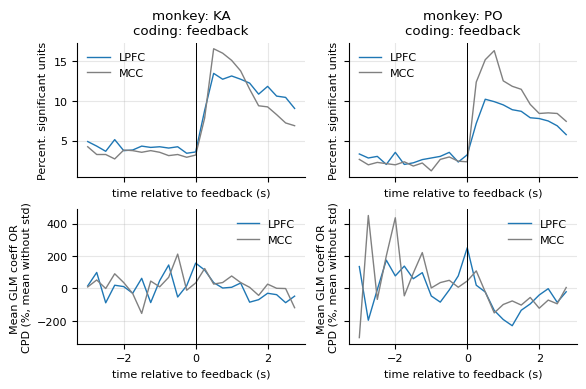

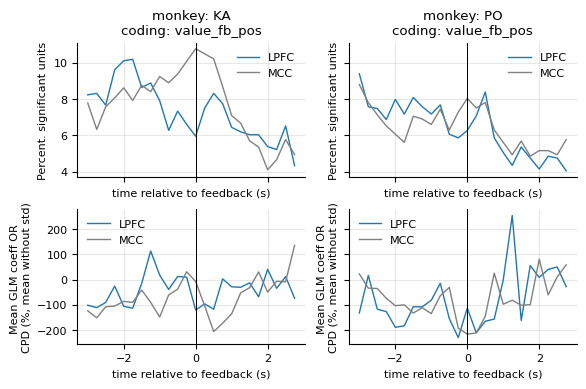

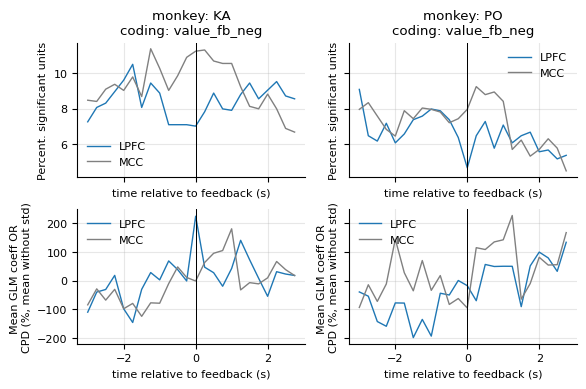

In [ ]:
# load data - 1-1 xarray datasets for all the conditions
ds_feedback_value_mixed_glm = load_res("feedback_value_mixed_glm", add_target_to_fname=False)

regressor_of_interest = "feedback"
time_of_interest =  [-3, 3] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_feedback_value_mixed_glm, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)

regressor_of_interest = "value_fb_pos"
time_of_interest =  [-3, 3] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_feedback_value_mixed_glm, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)

regressor_of_interest = "value_fb_neg"
time_of_interest =  [-3, 3] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_feedback_value_mixed_glm, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)

In [ ]:
# get the units that are significantly coding value after a negative outcome in the reward epoch with a negative coefficient
data_after = ds_feedback_value_mixed_glm.sel(time=slice(.5, 2))

units_after = []
for unit in data_after.unit.values:
    data_temp = data_after.sel(unit=unit)
    pvals = data_temp.p_vals_value_fb_neg
    coeffs = data_temp.coeffs_value_fb_neg
    # if any of the p-values is significant and the mean coefficient is NEGATIVE
    if any(pvals < 0.001) and np.mean(coeffs) > 0:
        units_after.append(unit)   
units_after = set(units_after)

# get the units that are significantly coding value in the expectation epoch with a positive coefficient
data_before = ds_feedback_value_glm.sel(time=slice(-1.5, 0))

units_before = []
for unit in data_before.unit.values:
    data_temp = data_before.sel(unit=unit)
    pvals = data_temp.p_vals_value_function
    coeffs = data_temp.coeffs_value_function
    # if any of the p-values is significant and the mean coefficient is POSITIVE
    if any(pvals < 0.001) and np.mean(coeffs) < 0:
        units_before.append(unit)
units_before = set(units_before)

# find the intersection
mixed_units = units_after.intersection(units_before)
mixed_units = sorted(list(mixed_units))

mixed_units


NameError: name 'ds_feedback_value_glm' is not defined

---
# Result 2: Current outcome representation (GLM PCD)

Here we have a GLM model of:

$$
\text{SpikeCount} \sim \text{Feedback} + R_{t-1} + R_{t-2} + R_{t-3} + R_{t-4}
$$

that we fit on 2 time-normalized trials' length [t, t+1]. We compute the CMD for the ***Feedback*** regressor only.

We compare 3 models:
- one with the simple history of outcomes
- one with the history being weighted by the cmw of anna
- an ANOVA model for comparison

In [ ]:
p_lim = 0.01

# load data - 1-1 xarray datasets for all the conditions
fnames = {
    #'cmw current fb': 'cmw_curr_fb_CPD',
    "no cmw curr. outcome CPD": "no_cmw_curr_fb_CPD",
    "cmw curr. outcome CPD": "cmw_curr_fb_CPD",
    "anova curr. outcome ": "anova_feedback",
}

dss = []
for model_name, fname in fnames.items():
    ds = load_res(fname, target=None)
    # shift time dimension with -7.5s
    ds["time"] = ds["time"] - (
        7.5 + ds["time"].values[0]
    )  # shift time dimension with -7.5s if not like that already#
    ds.attrs["model_name"] = model_name
    dss.append(ds)

plotting_func = prop_significants  # prop_significants
plot_summary_statistic(
    dss, plotting_func, title=f"CPD & ANOVA of current outcome", p_lim=p_lim, theme=1
)
plt.show()

##   Feedback per target (Anova)

In [ ]:
p_lim = 0.05

# load data - 1-1 xarray datasets for all the conditions
fnames = {
    "anova feedback": "anova_feedback",
}

dss = []
for target in [None, 1, 2, 3, "random"]:
    ds = load_res(fnames["anova feedback"], target=target)
    ds.attrs["model_name"] = f"tagert_{target}"
    dss.append(ds)

plotting_func = n_significants  # prop_significants
plot_summary_statistic(
    dss,
    plotting_func,
    title=f"Anova current outcome",
    p_lim=p_lim,
    theme=None,
    n_extra_trials=(0, 1),
)
plt.show()

In [ ]:
ds_unit_info = []
for ds in dss:
  for t in ds.time.data:
    ds_temp = ds.sel(time=t)
    ids_signif = ds_temp['p_vals'] <= p_lim
    signif_units = ds_temp.unit.data[ids_signif]
    
    for monkey in ['ka', 'po']:
      for area in ['LPFC', 'MCC']:
        units_temp = np.array([unit for unit in signif_units if unit.split('_')[0] == monkey and unit.split('_')[2] == area])
        ds_unit_info.append({
          'time': t,
          'target': ds.attrs['target_of_interest'],
          'monkey': monkey,
          'area': area,
          'set_signif_units': set(units_temp),
          'n_significants': len(units_temp)
        })
          
ds_unit_info = pd.DataFrame(ds_unit_info).sort_values(['time', 'target', 'monkey', 'area'])
ds_unit_info.head(20)

In [ ]:
def calculate_n_unis(ds_unit_info, monkey, area):
    """
    Calculate the number of units for different target conditions.

    Parameters:
    - ds_unit_info (DataFrame): The dataset containing unit information.
    - monkey (str): The monkey name.
    - area (str): The area name.

    Returns:
    - n_unis (DataFrame): The calculated number of units for each target condition.
    """

    n_unis = {}
    for t in ds_unit_info.time.unique():
        ds_unit_info_t = ds_unit_info[(ds_unit_info.time == t) & (ds_unit_info.monkey == monkey) & (ds_unit_info.area == area)]

        units_t1 = ds_unit_info_t[ds_unit_info_t.target == '1']['set_signif_units'].values[0]
        units_t2 = ds_unit_info_t[ds_unit_info_t.target == '2']['set_signif_units'].values[0]
        units_t3 = ds_unit_info_t[ds_unit_info_t.target == '3']['set_signif_units'].values[0]

        n_unis[t] = {
            '1 - (2+3)': len(set(units_t1) - (set(units_t2) | set(units_t3))),
            '2 - (1+3)': len(set(units_t2) - (set(units_t1) | set(units_t3))),
            '3 - (1+2)': len(set(units_t3) - (set(units_t1) | set(units_t2))),
            '1 & 2 & 3': len(set(units_t1) & set(units_t2) & set(units_t3)),
        }
    n_unis = pd.DataFrame(n_unis).T
    return n_unis

n_unis = calculate_n_unis(ds_unit_info, 'ka', 'LPFC')
n_unis

In [ ]:
# show venn at t=4.5
from matplotlib_venn import venn3
from matplotlib_venn import venn2
t_of_interest = 0

ds_unit_info_t = ds_unit_info[ds_unit_info.time == t_of_interest]

units_t1 = ds_unit_info_t[ds_unit_info_t.target == '1']['set_signif_units'].values[0]
units_t2 = ds_unit_info_t[ds_unit_info_t.target == '2']['set_signif_units'].values[0]
units_t3 = ds_unit_info_t[ds_unit_info_t.target == '3']['set_signif_units'].values[0]

venn3([set(units_t1), set(units_t2), set(units_t3)], ('target 1', '2target 2', 'target 3'))
plt.title(f'Venn diagram of significant units at t={t_of_interest}s')
plt.show()


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(13, 10), sharex=True, sharey=True)

# colors are from the venn diagram
colors = ['tab:orange', 'tab:green', 'tab:purple', 'grey']

for m, monkey in enumerate(['ka', 'po']):
    for a, area in enumerate(['LPFC', 'MCC']):
        ax = axs[m, a]
        n_unis = calculate_n_unis(ds_unit_info, monkey, area)
        for c, col in enumerate(n_unis.columns):   
            ax.plot(n_unis.index, n_unis[col], label=col, color=colors[c])
    
            ax.legend()
            ax.set_xlabel('time (s)')
            ax.set_ylabel('number of units')
            plot_keypoints(ax, n_extra_trials=(0, 1), fontsize=8, xlabels='both')
            ax.grid(alpha=0.3)

            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

            ax.set_title(f'monkey: {monkey}, area: {area}')

            # vertical line at 4s
            ax.axvline(t_of_interest, color='grey', linestyle='--')

plt.show()

In [ ]:
t_of_interest = 4
ds_unit_info_t = ds_unit_info[ds_unit_info.time == t_of_interest]
print(f'Unit coding for target 1 only at time {t_of_interest}s: \n{set(ds_unit_info_t[ds_unit_info_t.target == "1"]["set_signif_units"].values[0]) - (set(ds_unit_info_t[ds_unit_info_t.target == "2"]["set_signif_units"].values[0]) | set(ds_unit_info_t[ds_unit_info_t.target == "3"]["set_signif_units"].values[0]))}')

---
# Result 3: Target (anova)

In [ ]:
p_lim = 0.01

# load data - 1-1 xarray datasets for all the conditions
fname = "fd_value_cpd"

ds_full_feedback = load_res(fname, add_target_to_fname=False)
# shift time dimension with -7.5s

regressor_of_interest = "feedback"
time_of_interest =  [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_full_feedback, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)

# save figure
'''fig.savefig(
    os.path.join('figs', f"glm_{regressor_of_interest}_prop_significant_units.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)'''

regressor_of_interest = "R_1_R_2_R_3_R_4_R_5_R_6"
time_of_interest =  [-2, 1] # [-.2, 3] 
fig, ax = plot_prop_significant_units(
    ds_full_feedback, 
    regressor_of_interest=regressor_of_interest,
    time_of_interest=time_of_interest,
    plim=0.01, 
    title=None)

# save figure
'''fig.savefig(
    os.path.join('figs', f"glm_{regressor_of_interest}_prop_significant_units.svg"),
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)'''



In [ ]:
p_lim = 0.01

# load data - 1-1 xarray datasets for all the conditions
fnames = {
    #'cmw current fb': 'cmw_curr_fb_CPD',
    'target ANOVA': 'anova_target',
    }

dss = []
for model_name, fname in fnames.items():
    ds = load_res(fname, target=None)
    # shift time dimension with -7.5s 
    ds['time'] = ds['time'] - (7.5 + ds['time'].values[0])  # shift time dimension with -7.5s if not like that already
    ds.attrs['model_name'] = model_name
    dss.append(ds)

plotting_func = prop_significants  # prop_significants
plot_summary_statistic(dss, plotting_func, title= f'ANOVA of target with or without CMW weighting', p_lim=p_lim, theme=1)
plt.show()

In [ ]:
# print the list of units that are significant at t=2.5s
t = 2.5
x = dss[0].p_vals.sel(time=t)
units=set(x[x <= p_lim].unit.data)
# sort units
units = sorted(units, key=lambda x: int(x.split('_')[1]))
units

## Target at switch

In [ ]:
p_lim = 0.05

# load data - 1-1 xarray datasets for all the conditions
fnames = {
    'previous choice at switch': 'anova_previous_choice_at_switch',
    'upcoming choice at switch': 'anova_upcoming_choice_at_switch',
    }

dss = []
for model_name, fname in fnames.items():
    ds = load_res(fname, target=None)
    # shift time dimension with -7.5s 
    ds['time'] = ds['time'] # shift time dimension with -7.5s if not like that already
    ds.attrs['model_name'] = model_name
    dss.append(ds)

plotting_func = prop_significants  # prop_significants
plot_summary_statistic(dss, plotting_func, title= f'ANOVA of value with or without CMW weighting', p_lim=p_lim, theme=1)
plt.show()

---
# Value (anova)


In [ ]:
p_lim = 0.05

# load data - 1-1 xarray datasets for all the conditions
fnames = {
    #'cmw current fb': 'cmw_curr_fb_CPD',
    'value': 'anova_value',
    }

dss = []
for model_name, fname in fnames.items():
    ds = load_res(fname, target=None)
    # shift time dimension with -7.5s 
    ds['time'] = ds['time'] # shift time dimension with -7.5s if not like that already
    ds.attrs['model_name'] = model_name
    dss.append(ds)

plotting_func = prop_significants  # prop_significants
plot_summary_statistic(dss, plotting_func, title= f'ANOVA of value with or without CMW weighting', p_lim=p_lim, theme=1)
plt.show()